# 🐶 End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cage and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data

The data we're using is from Kaggle's dog breed identification competition
https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4. Features

Som information about the data:
* We're dealing with images (unstructured data) so it's probably best we use learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10000+ images in the training set (these images have labels)
* There are around 10000+ images in the test set (these images have no labels, because we'll want to predict them)

In [1]:
# Unzip the uploaded data into Google Drive
!unzip -n "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision"
!ls -1Up "drive/MyDrive/Dog Vision/test" | grep -v / | wc -l
!ls -1Up "drive/MyDrive/Dog Vision/train" | grep -v / | wc -l

Archive:  drive/MyDrive/Dog Vision/dog-breed-identification.zip
10371
10222


Get our workspace ready
* Import TensorFlow 2.x ✅
* Import TensoeFloq Hub ✅
* Make sure we're using a GPU ✅

In [2]:
# !pip install tensorflow


In [3]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("TF hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available (YESSSSS!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.11.0
TF hub version: 0.13.0
GPU available (YESSSSS!!!)


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numericalformat. So that's what we'll be doing first. Turning our images into Tensors (numerical representations)

Let's start by accessing our data and checking out the labels

In [4]:
# Checkout the labels of our data
import pandas as pd

labels_csv = pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


<Axes: >

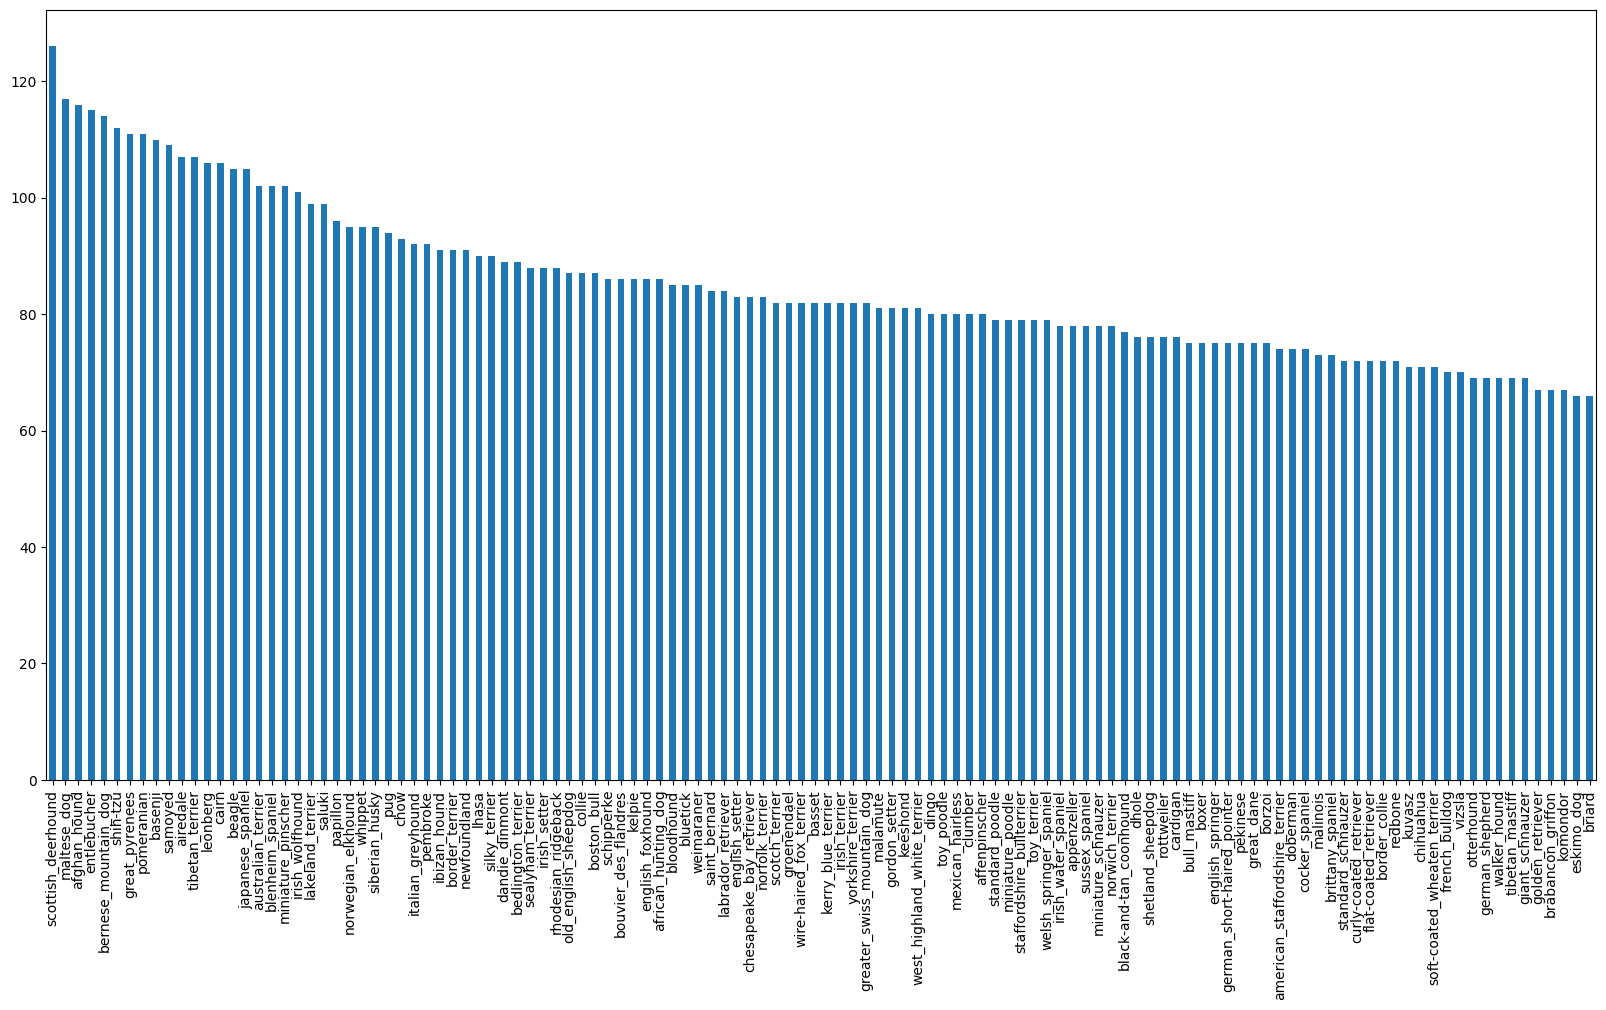

In [5]:
# How many images are there for each breed
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [6]:
labels_csv["breed"].value_counts().median()

82.0

In [7]:
 # Lets view an image
 from IPython.display import Image

 # Image("drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

Let's get a list of all of our image file pathnames.

In [8]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [9]:
# Create pathnames from image ID's
filenames = [f"drive/MyDrive/Dog Vision/train/{fname}.jpg" for fname in labels_csv["id"]]

# Check thge first 10
filenames[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [10]:
# Check whether number of filenames matches number of actual image files
from pathlib import Path

path = Path("drive/MyDrive/Dog Vision/train")
path_files = [str(x) for x in path.glob('*') if x.is_file()]

path_file_count = len(path_files)
print(path_file_count, len(filenames))
if path_file_count == len(filenames):
  if set(filenames) == set (path_files):
    print("All files found!!!")


10222 10222
All files found!!!


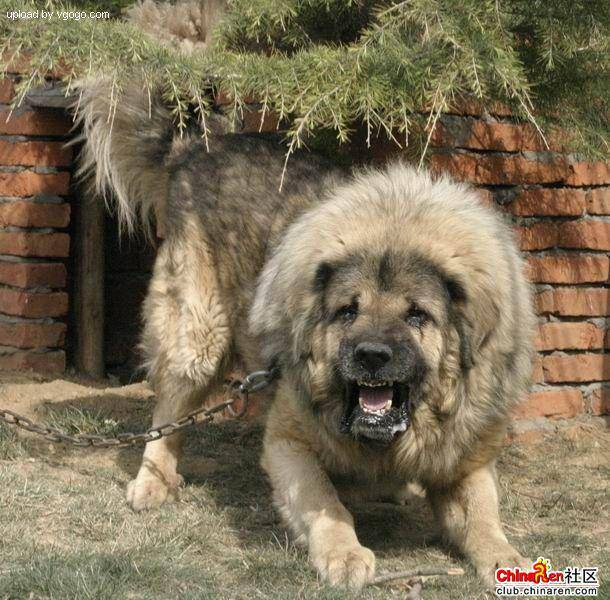

In [11]:
# One more check
Image(filenames[9000])

In [12]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, lets prepare our labels.

In [13]:
import numpy as np

labels = labels_csv['breed'].to_numpy()
# labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [14]:
len(labels)

10222

In [15]:
# See if number of labels matches number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames")

Number of labels matches number of filenames


In [16]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [17]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [18]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]

In [19]:
len(boolean_labels)

10222

In [20]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [21]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set
Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [22]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [23]:
# Set number of images to sue for experimenting
NUM_IMAGES = 1000 # @param {type:"slider", min:1000, max:10000}

In [24]:
# Set the random seed
np.random.seed(42)

# Import train_test_split from Scikit-Learn
from sklearn.model_selection import train_test_split

# Split them into training and validation using NUM_IMAGES 
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES], 
                                                  test_size=0.2,
                                                  random_state=42)

In [25]:
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [26]:
# Check out the training data (image file paths and labels)
X_train[:5], y_train[:2]

(['drive/MyDrive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, 

### Preprocessing Images (turning Images into Tensors)

To preprocess our images into tensors, we are going to write a function which does a few things:

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1
5. Resize the `image` to be a shape of (224, 224)
6. Return modified `image`

Before we do, lets see what importing an image looks like

In [27]:
# Convert an image to a numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

## Turning our data into batches

Why turn our data into batches?

Lets say youre trying to process 10000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be).

In order to use TensorFlow effectively, we need the data in the form of Tensor tuples which look like this:
`(image, label)`

In [28]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

In [29]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [30]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

Now we've got a way to turn our data into tuples of Tensors in the form: `(image, label)`, lets make a function to return all of our data (`X` & `y`) into batches

In [31]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [32]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend. Lets visualize them

In [33]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")

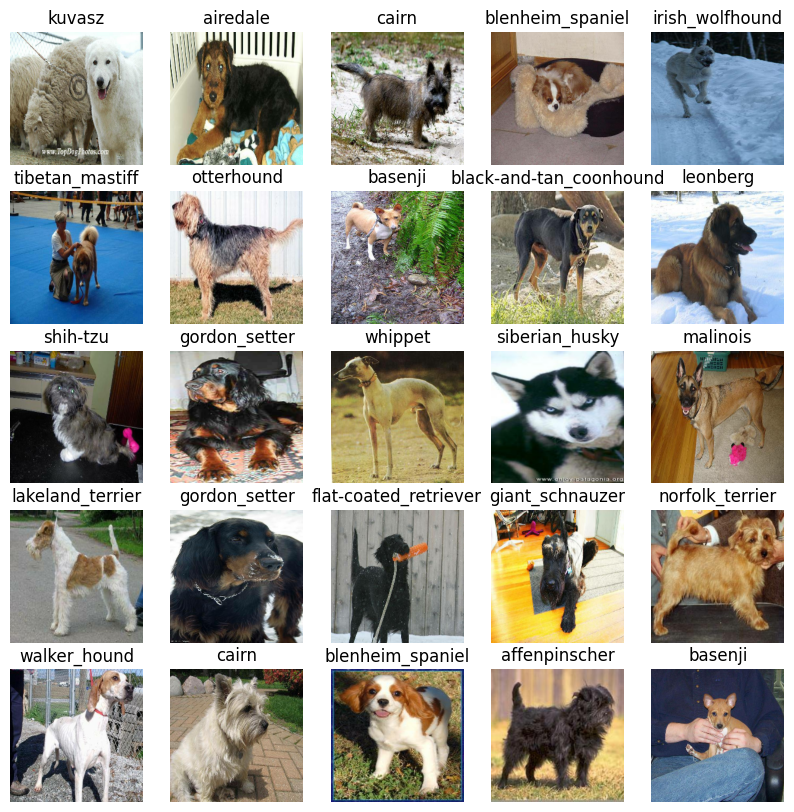

In [34]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

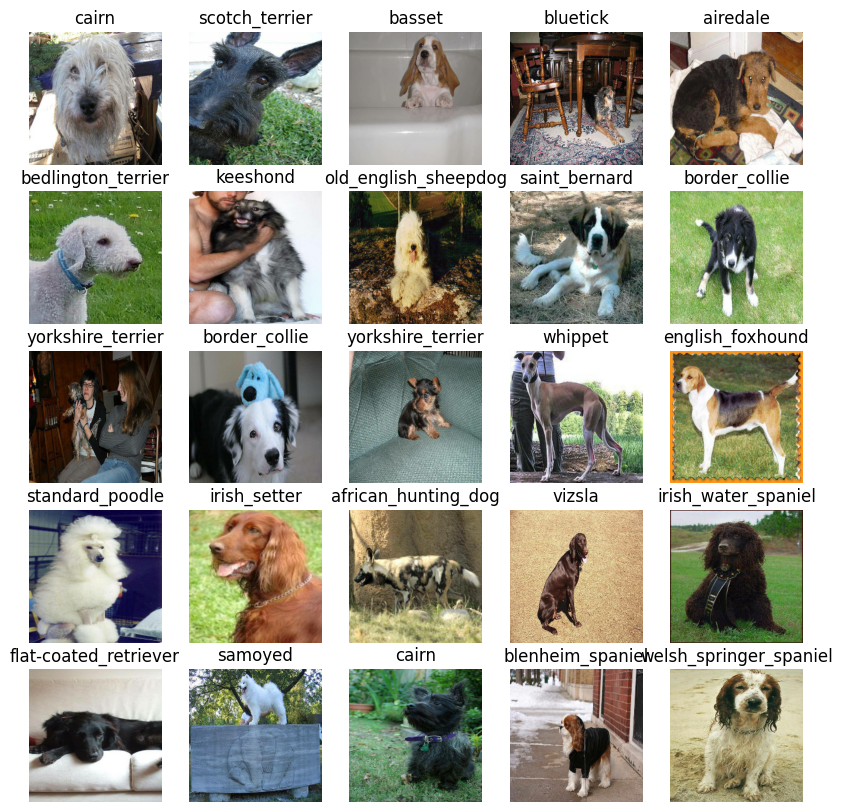

In [35]:
# Visualize validation images from the validation data batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model
Before we build a model, there are a few things we need to define_aliases

* The input shape (our images shape, in the form of Tensors) to our model
* The output shape (our image labels, in the form of Tensors) of our model
* The URL of the model we want to use from TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/5

In [36]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/5"

Now, we've got our inputs, outputs, and model ready to go. Lets put them together into a Keras deep learning model!

Knowing this, lets create a function which:
* Takes the input shape, output shape, and the model we've chosen as parameters.
* Defines the laters in a Keras model in squential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape itll be getting).
* Returns the model.

All of these steps can be found here: https://tensorflow.org/guide/keras/overview

In [37]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.Adam(), # A friend telling our model how to improve its guesses
      metrics=["accuracy"] # We'd like this to go up
  )

  # Build the model
  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting
  
  return model

In [38]:
# Create a model and check its details
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/5


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              6158505   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 6,278,745
Trainable params: 120,240
Non-trainable params: 6,158,505
_________________________________________________________________


## Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress, or stop training early if a model stops improving.

We'll create two callbacks:

* One for TensorBoard, which helps track our models progress, and
* Another for early stopping which prevents our model from training for too long.

### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:

1. [x] Load the TensorBoard notebook Extension  
2. [x] Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. [ ] Visualize our models training logs with the `%tensorboard` magic function (we'll do this after model training).

In [39]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [40]:
import datetime

logpath = "drive/MyDrive/Dog Vision/cb_logs"

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = Path(logpath,
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early stopping Callback

Early stopping healps stop our model from overfitting by stopping training if a certain evaluation metric stops improving

https://keras.io/api/callbacks/early_stopping/

In [41]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) # stops after 3 rounds of no improvements

### Training a model (on a subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [42]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [43]:
# Check for GPU availability
print("GPU", "available (YESSSSS!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU available (YESSSSS!!!)


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model

In [44]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping])
  
  return model

In [45]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/5
Epoch 1/100
25/25 [==============================] - 144s 4s/step - loss: 4.4893 - accuracy: 0.1187 - val_loss: 3.4471 - val_accuracy: 0.2850
Epoch 2/100
25/25 [==============================] - 3s 118ms/step - loss: 1.6695 - accuracy: 0.6963 - val_loss: 2.2292 - val_accuracy: 0.5200
Epoch 3/100
25/25 [==============================] - 4s 145ms/step - loss: 0.5811 - accuracy: 0.9425 - val_loss: 1.7066 - val_accuracy: 0.6000
Epoch 4/100
25/25 [==============================] - 4s 144ms/step - loss: 0.2494 - accuracy: 0.9900 - val_loss: 1.4995 - val_accuracy: 0.6350
Epoch 5/100
25/25 [==============================] - 4s 158ms/step - loss: 0.1445 - accuracy: 0.9987 - val_loss: 1.4050 - val_accuracy: 0.6750
Epoch 6/100
25/25 [==============================] - 3s 119ms/step - loss: 0.0986 - accuracy: 1.0000 - val_loss: 1.3605 - val_accuracy: 0.6900
Epoch 7/100
25/25 [==============================]

### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize its contents.

In [46]:
# %tensorboard --logdir ../images/Dog\ Vision/cb_logs

## Making and evaluating predictions using a trained model

In [47]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1) # verbose shows us how long there is to go
predictions

7/7 [==============================] - 4s 143ms/step


array([[9.7056469e-03, 5.1946053e-04, 1.1982743e-03, ..., 4.3155384e-04,
        3.9798618e-04, 2.1144780e-04],
       [2.9952587e-03, 6.5308334e-03, 2.1594055e-02, ..., 5.3518391e-03,
        1.2018142e-03, 1.1371345e-03],
       [6.8820013e-06, 8.4930369e-05, 1.2692370e-04, ..., 5.4605014e-04,
        3.1229960e-05, 1.9245055e-04],
       ...,
       [7.3618270e-05, 1.7636970e-03, 4.3689567e-04, ..., 1.6997507e-04,
        4.0572788e-05, 3.2225426e-03],
       [3.8999412e-04, 2.0150395e-05, 8.7066102e-05, ..., 3.3058575e-05,
        1.0265676e-04, 6.4728083e-03],
       [8.4942830e-04, 3.8204595e-05, 3.4273215e-04, ..., 9.7364215e-03,
        1.5929553e-03, 3.7934406e-05]], dtype=float32)

In [48]:
# Check the shape of predictions
predictions.shape

(200, 120)

In [49]:
# First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_breeds[np.argmax(predictions[0])]}") # the predicted label

[9.70564689e-03 5.19460533e-04 1.19827432e-03 6.48176792e-05
 3.90472327e-04 7.70184924e-05 6.13879599e-03 1.73805180e-04
 7.22473778e-04 3.16787919e-05 3.69028654e-04 1.95039925e-03
 1.42625696e-03 1.55651607e-04 2.13105784e-04 5.43088390e-05
 4.52443346e-05 6.58280179e-02 4.39817115e-04 8.02861905e-06
 4.69901925e-03 9.39611986e-04 1.13810107e-04 6.81722956e-03
 3.06515030e-05 6.04823763e-05 1.09677233e-01 2.41350310e-04
 3.64817883e-04 2.20741567e-04 2.68048490e-04 7.72400119e-04
 1.18844816e-03 7.22434488e-05 4.14908645e-05 2.37423759e-02
 1.48056773e-04 4.78803304e-05 3.61903076e-04 2.17716530e-04
 9.30620532e-04 1.84972068e-05 2.55776191e-04 4.59502953e-05
 1.29840364e-05 5.61265682e-04 3.63199681e-04 3.91116162e-04
 1.50860986e-03 1.32682937e-04 5.55371735e-05 5.52852689e-05
 5.39453654e-03 1.22065729e-04 2.07995763e-04 3.95310635e-05
 2.06805853e-04 2.23907805e-03 1.30220389e-04 4.02634554e-02
 8.84444817e-05 4.04500315e-05 1.22991018e-03 1.77374124e-04
 3.86941429e-05 2.575099

In [50]:
unique_breeds[39]

'english_foxhound'

Having the above functionality is great but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on!

**Note:** Prediction probabilities are also known as confidence levels.

In [51]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'lhasa'

In [52]:
type(predictions[81])

numpy.ndarray

Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare thsoe predictions to the validation labels (truth labels)

In [53]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
    """
    Takes a batched dataset of (image, label) Tensors and returns separate arrays of images and labels.
    """
    images = []
    labels = []

    #loop through unbatched data
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])
    
    return images, labels


# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some function to make these all a bit more visual.

We'll create a function which:
* [x] Takes an array of prediction probabilities, an array of truth labels, and an array of images and integers
* [x] Convert the prediction probabilities to a predicted label.
* [x] Plot the predicted label, its predicted probability, the truth label and the target image on a single plot.

In [54]:

def plot_pred(prediction_probabilities, labels, images, n=1):
    """
    View the prediction, ground truth, and image for sample n
    """
    pred_prob,true_label, image = prediction_probabilities[n], labels[n], images[n]
    
    # Get tje pred label
    pred_label = get_pred_label(pred_prob)
    
    # Plot image a& remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    
    # Change the color of the title depending if the prediction is right or wrong
    if pred_label == true_label:
        color = "green"
    elif pred_label != true_label:
        color = "red"
    
    # Change plot title to be predicted, probability of prediction, and truth
    plt.title("{} {:2.0f}% {}".format(pred_label,
                                  np.max(pred_prob)*100,
                                  true_label),
             color=color)

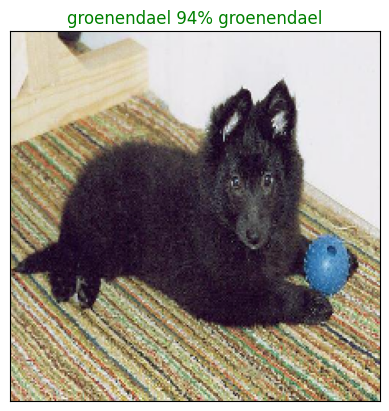

In [55]:
# View an example prediction, original image and truth label
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

Now we've got one function to visualize our models top prediction, lets make another to view our models top 10 prediction results.

This function will:
* [x] Take an input of prediction probabilities array and a ground truth array and an integer
* [x] Find the prediction using the `get_pred_label()`
* Find the top 10:
  * [x] Prediction probabilities indexes
  * [x] Prediction probabilities values
  * [x] Prediction labels
* [x] Plot the top 10 predictions probability values and labels, coloring the true label green

In [56]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels= top_10_pred_labels,
             rotation="vertical")
  
  # Change color of true labels
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")

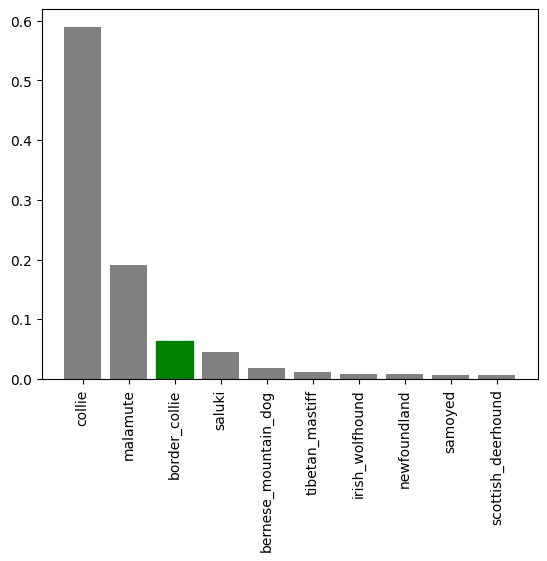

In [57]:
plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels, n=9)

Now we've got some function to help us visualize our predictions and evaluate our model, let's check out a few.

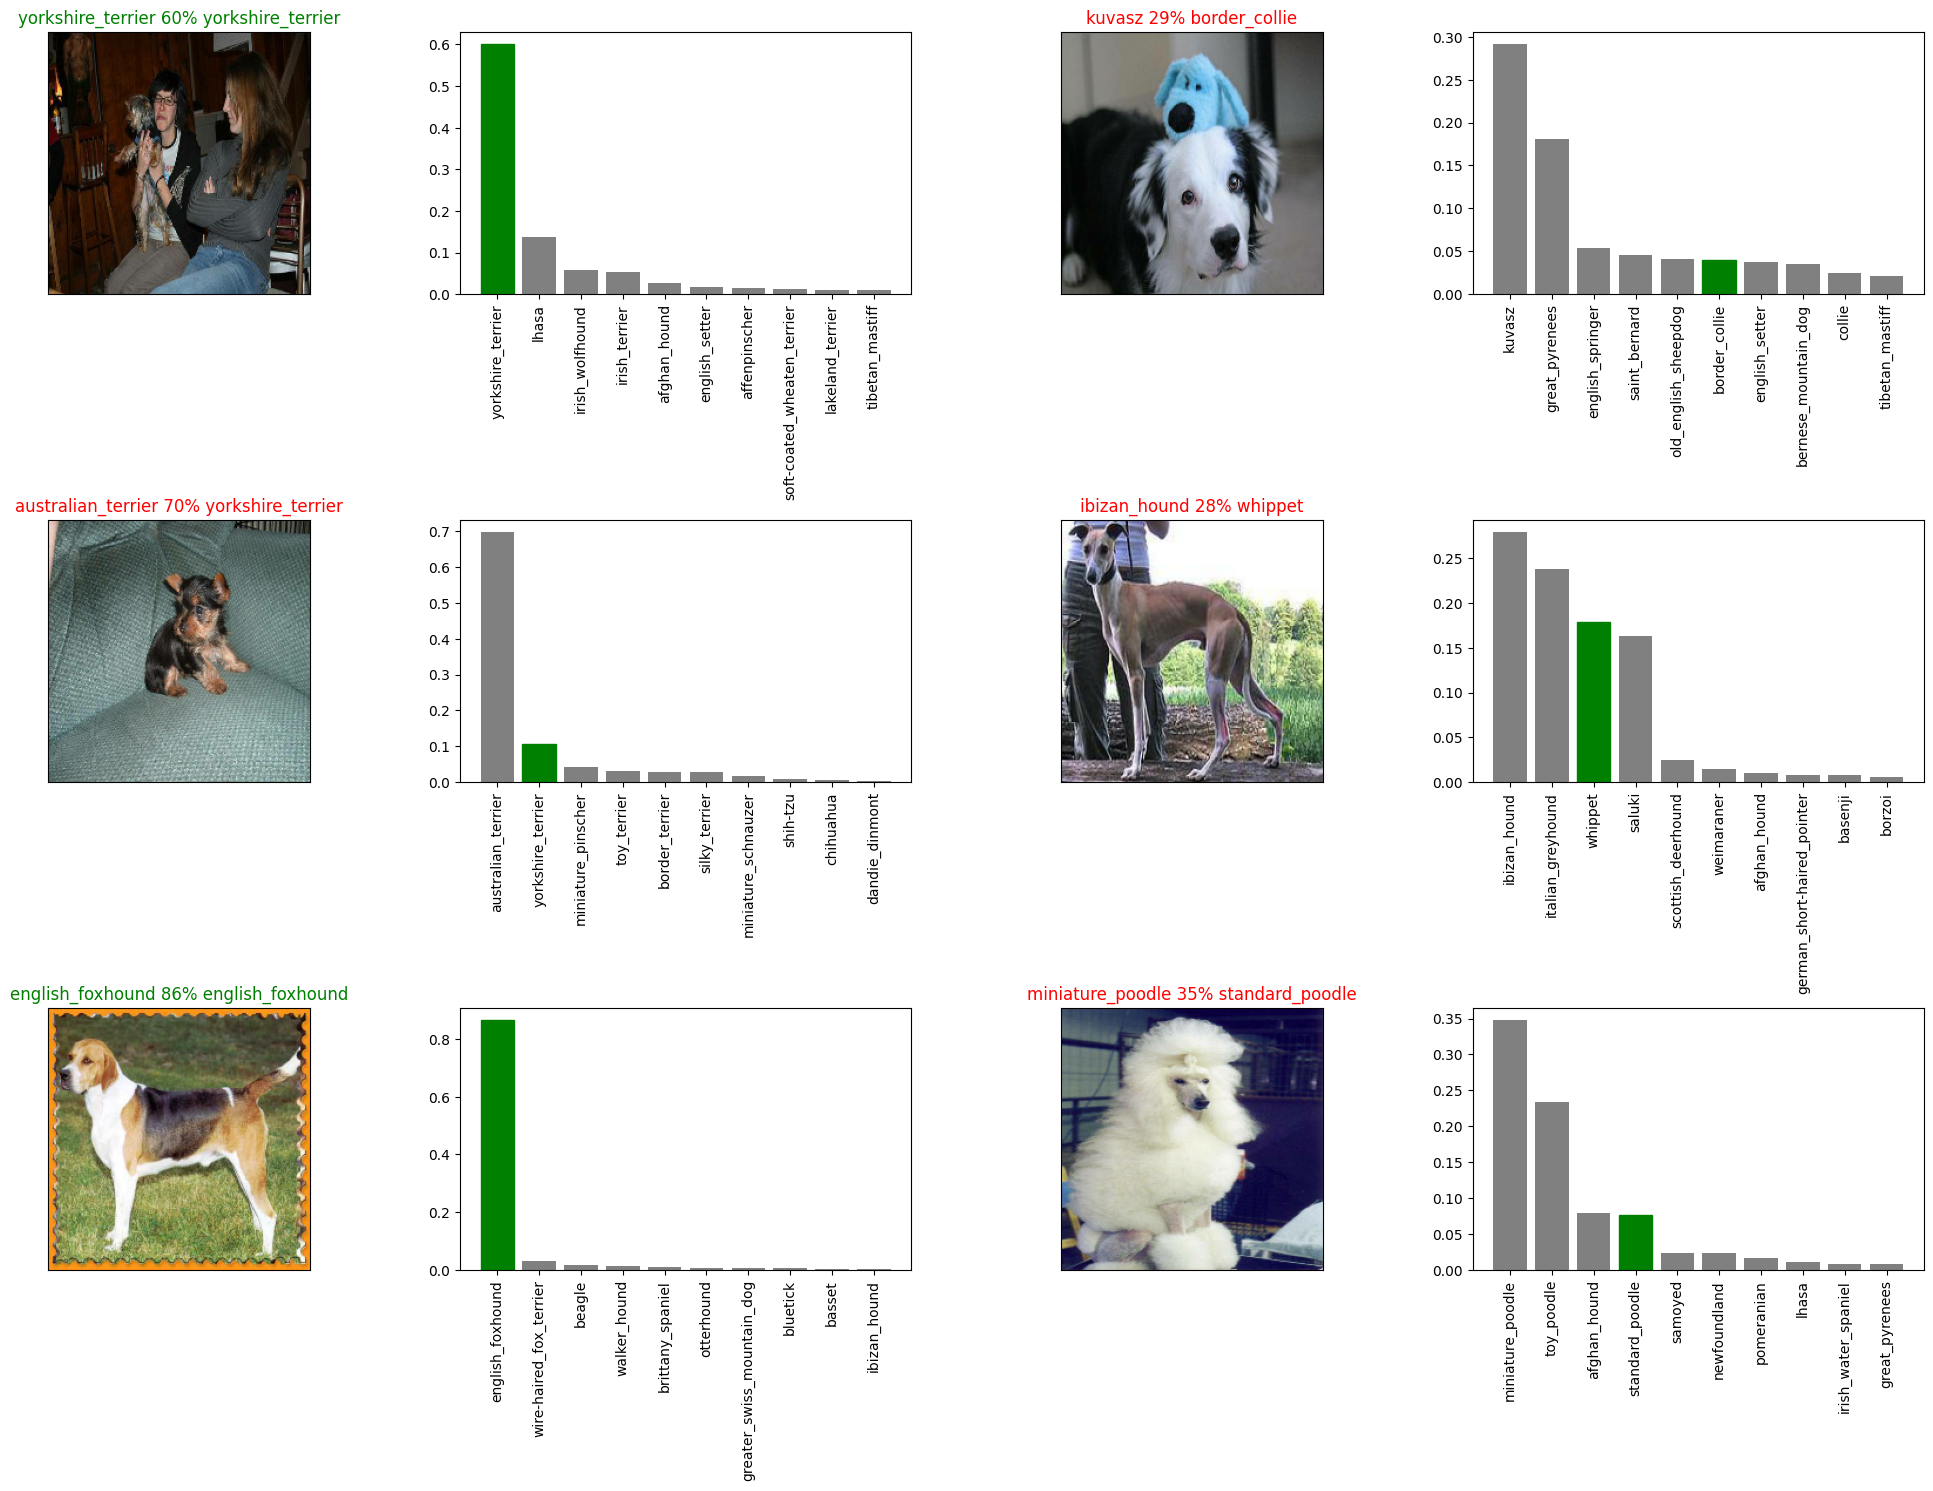

In [58]:
i_multiplier = 10
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(predictions, val_labels, val_images, i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(predictions, val_labels, i+i_multiplier)

plt.tight_layout(h_pad=1.0)
plt.show()

### Save and load models

In [59]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str).
  """
  # Create a model directory pathname with current time
  models_dir = Path("drive/MyDrive/Dog Vision/models")
  date_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
  file_name = date_time + "-" + suffix + ".h5"

  model_path = models_dir / file_name # save model format

  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [60]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

Now we've got functions to save and load a trained model, let's make sure they work!

In [61]:
# Save our model trained on 1000 images
saved_model_path = save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/MyDrive/Dog Vision/models/20230330-12251680179155-1000-images-mobilenetv2-Adam.h5...


In [62]:
# Load a trained model
loaded_1000_image_model = load_model("drive/MyDrive/Dog Vision/models/20230329-21071680124032-1000-images-mobilenetv2-Adam.h5")

Loading saved model from: drive/MyDrive/Dog Vision/models/20230329-21071680124032-1000-images-mobilenetv2-Adam.h5


In [63]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 97ms/step - loss: 1.2727 - accuracy: 0.6900


[1.2726999521255493, 0.6899999976158142]

In [64]:
# Evaluate the laoded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 83ms/step - loss: 1.2343 - accuracy: 0.7000


[1.234281063079834, 0.699999988079071]

### Training a big dog model 🐶 (on full data set)

In [65]:
len(X), len(y)

(10222, 10222)

In [66]:
# Create a data batch with the full data set
full_data = create_data_batches(X, y)

Creating training data batches...


In [67]:
full_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [68]:
# Create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/5


In [69]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()

# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

**Note:** Running the cell below will take a little while (maybe up to 30 minutes for the first epoch) because the GPU we're using in the runtime has to load all of the images into memory.

In [70]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 38s 105ms/step - loss: 1.2876 - accuracy: 0.6834
Epoch 2/100
320/320 [==============================] - 34s 106ms/step - loss: 0.3617 - accuracy: 0.8969
Epoch 3/100
320/320 [==============================] - 33s 103ms/step - loss: 0.2091 - accuracy: 0.9421
Epoch 4/100
320/320 [==============================] - 33s 101ms/step - loss: 0.1308 - accuracy: 0.9699
Epoch 5/100
320/320 [==============================] - 33s 103ms/step - loss: 0.0890 - accuracy: 0.9823
Epoch 6/100
320/320 [==============================] - 34s 106ms/step - loss: 0.0647 - accuracy: 0.9908
Epoch 7/100
320/320 [==============================] - 32s 101ms/step - loss: 0.0482 - accuracy: 0.9936
Epoch 8/100
320/320 [==============================] - 34s 105ms/step - loss: 0.0382 - accuracy: 0.9967
Epoch 9/100
320/320 [==============================] - 33s 103ms/step - loss: 0.0299 - accuracy: 0.9977
Epoch 10/100
320/320 [==============================] - 32s 101m

In [71]:
saved_model_path = save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: drive/MyDrive/Dog Vision/models/20230330-12361680179771-full-image-set-mobilenetv2-Adam.h5...


In [72]:
# Load in the full model
loaded_full_model = load_model("drive/MyDrive/Dog Vision/models/20230329-19131680117181-full-image-set-mobilenetv2-Adam.h5")

Loading saved model from: drive/MyDrive/Dog Vision/models/20230329-19131680117181-full-image-set-mobilenetv2-Adam.h5


In [73]:
len(X)

10222

## Making predictions on the test dataset

Since our model hsabeen trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we'll:
* [x] get the test file names
* [x] Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since the test data doesn't have lavels).
* Make a predictions array by passing the test batches to the `predict()` method called on our model.

In [74]:
# Load test image file names
test_path = Path("drive/MyDrive/Dog Vision/test")
test_filenames = [str(x) for x in test_path.glob('*') if x.is_file()]

In [75]:
test_filenames[:10]

['drive/MyDrive/Dog Vision/test/df38352b1f41c92d6750b87b55488ed4.jpg',
 'drive/MyDrive/Dog Vision/test/dd7fbb397a4968d9ae54d1d7b7a35ae6.jpg',
 'drive/MyDrive/Dog Vision/test/e5ad4cc7818e4eed04d209da177afa6f.jpg',
 'drive/MyDrive/Dog Vision/test/dcdffa00518844bd21499db49979f9c8.jpg',
 'drive/MyDrive/Dog Vision/test/e64d56f012476f124591a22648114a37.jpg',
 'drive/MyDrive/Dog Vision/test/e5b04613b4fb9744d4fa057a892b3ec8.jpg',
 'drive/MyDrive/Dog Vision/test/dea5b2d047b3cb7ce13234140c7bf5aa.jpg',
 'drive/MyDrive/Dog Vision/test/de2c6675c001726a96ad9d72ab229f3a.jpg',
 'drive/MyDrive/Dog Vision/test/e145bbebb9ad1e740256e460899a6b67.jpg',
 'drive/MyDrive/Dog Vision/test/e2c3376aeea1057337f02dfc48feee62.jpg']

In [76]:
len(test_filenames)

10371

In [77]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [78]:
test_data

<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

**Note:** Calling the `predict()` on our full model and passing it the test data batch will take a long time to run (about an ~1hr).

In [79]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

325/325 [==============================] - 172s 517ms/step


In [80]:
# Save predictions (NumPy array) to csv file (for access later)
np.savetxt("drive/MyDrive/Dog Vision/preds_array.csv", test_predictions, delimiter=",")

In [81]:
# Load predictions (NumPy array) from csv file
test_predictions = np.loadtxt("drive/MyDrive/Dog Vision/preds_array.csv", delimiter=",")

In [82]:
test_predictions[:10]

array([[8.42244219e-10, 4.27119744e-08, 1.24813215e-09, ...,
        1.09740510e-08, 7.19582949e-10, 2.08562348e-10],
       [2.85572998e-12, 1.13434351e-09, 7.03799649e-13, ...,
        6.10081360e-11, 5.39603118e-14, 9.87533406e-13],
       [1.55782800e-07, 1.51631798e-06, 2.05324852e-07, ...,
        1.90128048e-03, 1.61778047e-07, 1.08262084e-05],
       ...,
       [3.68872907e-06, 3.15812723e-11, 1.33633018e-11, ...,
        2.51129478e-10, 1.67817369e-08, 1.53823132e-09],
       [3.57226604e-08, 1.10140739e-07, 2.19793996e-08, ...,
        5.31149014e-10, 1.35194556e-09, 1.05918375e-07],
       [3.91260983e-05, 1.52163515e-09, 1.11633483e-06, ...,
        3.59855198e-06, 5.08698031e-05, 2.26286988e-06]])

In [83]:
test_predictions.shape

(10371, 120)

### Prepare the test data for Kaggle

Looking at the Kaggle sample submission, we find that it wants our models prediction probability outputs in a DataFrame with an ID and a column for each different dog breed.
https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format, we'll:
* [x] Create a pandas DataFrame with an ID column as well as a column for each dog breed.
* Add data to the ID column by extracting the test image ID's from their filepaths
* Add data (the prediction probabilities) to each of the dog breed columns.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [84]:
list(unique_breeds)

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [85]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [86]:
# Append test image ID's to predictions DataFrame
test_ids = [Path(path).stem for path in test_filenames]
test_ids[0]

'df38352b1f41c92d6750b87b55488ed4'

In [96]:
len(test_filenames)

10371

In [95]:
len(test_ids)

10371

In [87]:
preds_df["id"] = test_ids

In [88]:
preds_df.head()

id affenpinscher afghan_hound  \
0  df38352b1f41c92d6750b87b55488ed4           NaN          NaN   
1  dd7fbb397a4968d9ae54d1d7b7a35ae6           NaN          NaN   
2  e5ad4cc7818e4eed04d209da177afa6f           NaN          NaN   
3  dcdffa00518844bd21499db49979f9c8           NaN          NaN   
4  e64d56f012476f124591a22648114a37           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [89]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions

In [90]:
preds_df.head()

id  affenpinscher  afghan_hound  \
0  df38352b1f41c92d6750b87b55488ed4   8.422442e-10  4.271197e-08   
1  dd7fbb397a4968d9ae54d1d7b7a35ae6   2.855730e-12  1.134344e-09   
2  e5ad4cc7818e4eed04d209da177afa6f   1.557828e-07  1.516318e-06   
3  dcdffa00518844bd21499db49979f9c8   8.196083e-09  4.943657e-10   
4  e64d56f012476f124591a22648114a37   1.856073e-08  1.068469e-10   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         1.248132e-09  8.365711e-08                    2.977139e-08   
1         7.037996e-13  1.182511e-09                    6.006857e-12   
2         2.053249e-07  7.607355e-07                    3.419414e-03   
3         1.270486e-11  9.627872e-11                    5.621723e-07   
4         5.316475e-11  4.831327e-10                    1.572464e-08   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  4.865154e-10        8.612296e-10  1.064090e-08  2.082402e-08  ...   
1  1.119398e-12        1.717696e-14  1.689660e-10  3.996156e-10  ...   
2  3.431328e-05        2.331872e-06  1.375849e-04  4.817050e-05  ...   
3  4.997064e-06        1.527903e-06  9.999316e-01  1.066316e-07  ...   
4  7.889471e-10        4.965252e-08  4.360296e-05  1.987284e-08  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  8.692252e-10  1.014750e-11  3.432673e-07  1.613243e-06  3.409392e-07   
1  1.828857e-11  3.666317e-13  1.247633e-08  1.264242e-10  2.184695e-09   
2  3.309163e-07  5.961201e-08  5.656694e-02  8.935115e-07  1.739303e-06   
3  1.746587e-07  2.320776e-08  6.713465e-07  1.076106e-05  2.754363e-10   
4  9.504009e-07  3.112870e-06  5.560286e-07  1.861651e-11  2.938730e-08   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            3.562982e-10                 1.192530e-10  1.097405e-08   
1            3.525384e-10                 5.886507e-12  6.100814e-11   
2            4.488205e-06                 1.720343e-06  1.901280e-03   
3            2.107500e-08                 1.227729e-08  1.385675e-08   
4            1.081687e-11                 5.015854e-04  1.668363e-06   

   wire-haired_fox_terrier  yorkshire_terrier  
0             7.195829e-10       2.085623e-10  
1             5.396031e-14       9.875334e-13  
2             1.617780e-07       1.082621e-05  
3             2.062266e-06       1.262239e-09  
4             1.990784e-06       3.136345e-06  

[5 rows x 121 columns]

In [91]:
# Save our predictions dataframe to CSV for submission to Kaggle
preds_df.to_csv("drive/MyDrive/Dog Vision/full_model_predictions_submission_1_mobilenetV2.csv",
                index=False)

In [92]:
preds_df.shape

(10371, 121)

In [93]:
preds_df.shape

(10371, 121)